### ____________________________________________________________________________________________________

<div style="width:100%;text-align: right;">
    <img src="ensae.png" /> </div>
<div style="width:100%;text-align: center;">
   <br>
    <strong style="font-size:20px;">Projet de Machine Learning</strong>
    <br>
    <br>
    ***************
    <br>
</div>

<div style="width:100%;text-align: center;">
    <img src="seattle_image.png" style="width:35%;height:100%;" /> <br>
    <span style="font-size:20px;">SEA Building Energy Benchmarking : Prediction of Building Energy <br><strong>Partie Modélisation</strong></span>
</div>
    <br>
    <br>
<div style="width:100%;text-align: center;">
<strong>Janvier 2022</strong>
    </div>

### ____________________________________________________________________________________________________

Cette partie du projet est dédiée à la modélisation en tant que telle. Pour voir le Pré-traitement <a href="Preprocessing.ipynb" target="_blank">Cliquer ici</a>

# Sommaire

* [Modelling](#modelling)
    * [Installation de packages et importation de la CleanedDataSet](#PackImport)
    * [Normalité de nos variables cibles](#normality)
    * [Préparation des jeux d'entrainement et de test](#traintest)
    * [Un premier modèle : la Régression linéaire -- LinearRegression()](#linearreg)
    * [Comparaison de différents modèles de Regression](#modelComparison)
    * [RandomForestRegressor](#RandomForest)
        * [Score (train et test) et métriques](#ScoreMetr)
        * [Tuning des hyperparamètres](#TuningHyper)
        * [Features importance](#Fimport)
        * [LearningCurve](#LearningCurveRF)
        * [Prédiction et tabulation de quelques valeurs avec la métrique MSE](#PredictRF)
    * [Ride Regression](#ridgereg)
        * [Score (train et test) et métriques && Tuning des hyperparamètres](#ScoreMetrHyperRR)
        * [LearningCurve](#LearningCRR)
        * [Features importance](#FImportRR)
        * [Prédiction et tabulation de quelques valeurs avec la métrique MSE](#PredictRR)
    * [Correction des valeurs aberrantes](#aberantes)
    * [Encodage des variables catégorielles en numeric features](#encodage)
    * [Exportation de la base final](#export)

# Modelling <a class="anchor" id="modelling"></a>

In [71]:
!pip install statsmodels

<a class="anchor" id="PackImport"></a>

In [18]:
## Importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve, KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import *
from yellowbrick.model_selection import LearningCurve
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance
from yellowbrick.model_selection import ValidationCurve
import statsmodels.stats.diagnostic as smsd
import matplotlib.pyplot as plt

#### Importation de la base traitée

In [4]:
CleanedData=pd.read_csv("Clean_Data.csv")

In [6]:
CleanedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7209 entries, 0 to 7208
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   OSEBuildingID                             7209 non-null   float64
 1   DataYear                                  7209 non-null   float64
 2   NumberofFloors                            7209 non-null   float64
 3   PropertyGFATotal                          7209 non-null   float64
 4   PropertyGFAParking                        7209 non-null   float64
 5   ENERGYSTARScore                           7209 non-null   float64
 6   SiteEUI(kBtu/sf)                          7209 non-null   float64
 7   SourceEUIWN(kBtu/sf)                      7209 non-null   float64
 8   SourceEUI(kBtu/sf)                        7209 non-null   float64
 9   SteamUse(kBtu)                            7209 non-null   float64
 10  Electricity(kBtu)                   

Nous rappelons que nos variables targets sont les suivantes:

     1 - TotalGHGEmissions
     2 - SiteEnergyUse(kBtu)

In [7]:
#### Suppression de quelques variables
var=['OSEBuildingID','ENERGYSTARScore','DataYear']
CleanedData.drop(var,inplace=True, axis=1)

In [8]:
Y= CleanedData[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]
X= CleanedData.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)

## Normalité de nos variables cibles <a class="anchor" id="normality"></a>

Nos variables cibles, suivent-elles une tendance normale?

In [11]:
for i in Y.columns:
    statistic, p_value = normaltest(Y[i])
    if p_value<0.05:
        print("La distribution de la variable **"+i+"** n'est pas normale")
    else:
        print("La distribution de la variable **"+i+"** est normale")

La distribution de la variable **TotalGHGEmissions** n'est pas normale
La distribution de la variable **SiteEnergyUse(kBtu)** n'est pas normale


### Que donnerait passage à l'échelle logarithmique sur les distributions des variables targets ?

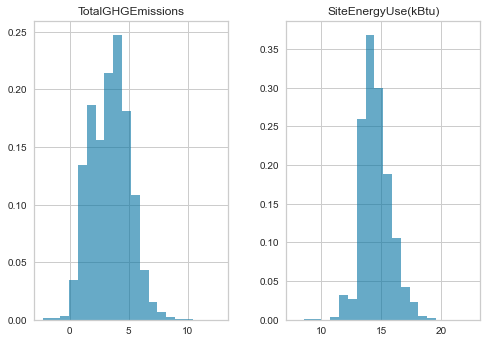

In [12]:
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
Y_log.hist(bins=20, density=True, alpha=0.6, color='b')  
plt.show()

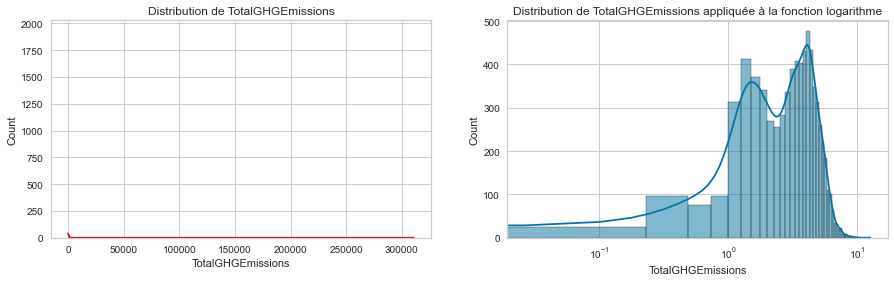

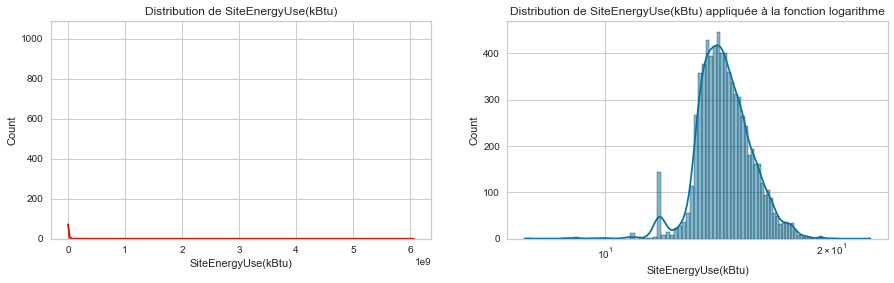

In [15]:
for i in Y.columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    sns.histplot(Y[i], color='r', kde=True, ax=axes[0])
    axes[0].set_title('Distribution de '+i)
    ##axes[0].set_xlim(xmin=0,xmax=100)
    ##axes[0].set_ylim(ymin=0,ymax=50)

    log_y = np.log(Y[i])
    sns.histplot(log_y, color='b', kde=True, ax=axes[1])
    axes[1].set_title('Distribution de '+i+' appliquée à la fonction logarithme')
    axes[1].set_xscale('log');

Même si les variables ne suivent pas une tendance normale, l'application de la fonction logarithme s'approche quand-même de la normale.

##### En appliquant la méthode du minmax, suivront-elles une tendance normale?

In [16]:
min_values = np.min(Y, axis = 0)
max_values = np.max(Y, axis = 0)

target_normalized = (Y - min_values)/(max_values - min_values)

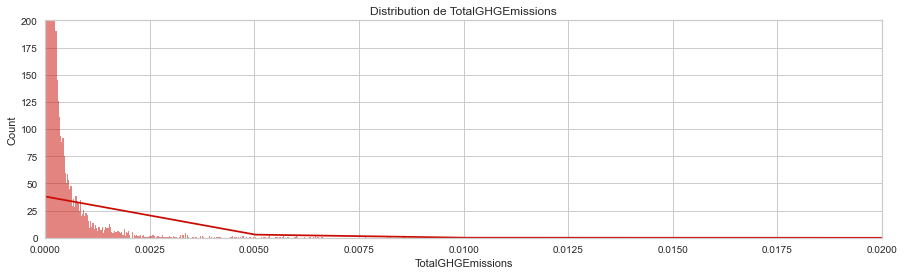

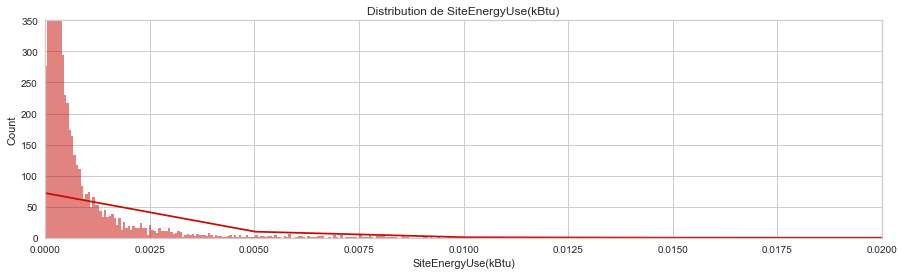

In [17]:
for i in target_normalized.columns:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    sns.histplot(target_normalized[i], color='r', kde=True, ax=axes)
    axes.set_title('Distribution de '+i)
    if i=='TotalGHGEmissions':
        b=200
    else:
        b=350
    plt.xlim(0,0.02)
    plt.ylim(0,b)

La normalisation avec la méthode du **min-max** donne également une distribution qui n'est pas normale. Nous allons à présent continuer avec la distribution obtenue en appliquant le log.

## Préparation des jeux d'entrainement et de test <a class="anchor" id="traintest"></a>
Afin de tester notre meilleur modèle sur des données "inconnues", nous allons subdiviser (split) notre jeu de données en deux parties pour obtenir un jeu d'entrainement et un jeu de test (20% des données)

In [19]:
log_y=np.log(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 5767 lignes,
Test: 1442 lignes.



In [20]:
log_y.columns

Index(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], dtype='object')

In [21]:
X.columns

Index(['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SiteEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'OHE_Campus', 'OHE_Multifamily',
       'OHE_NonResidential', 'OHE_SPS-District K-12',
       'OHE_Autres_Neighborhood', 'OHE_BALLARD', 'OHE_CENTRAL',
       'OHE_DELRIDGE NEIGHBORHOODS', 'OHE_DOWNTOWN', 'OHE_EAST',
       'OHE_GREATER DUWAMISH', 'OHE_LAKE UNION', 'OHE_MAGNOLIA / QUEEN ANNE',
       'OHE_NORTH', 'OHE_NORTHEAST', 'OHE_NORTHWEST', 'OHE_SOUTHEAST',
       'OHE_SOUTHWEST', 'OHE_Autres_LargestPropertyUseType',
       'OHE_Distribution Center', 'OHE_Hotel', 'OHE_K-12 School',
       'OHE_Multifamily Housing', 'OHE_Non-Refrigerated Warehouse',
       'OHE_Office', 'OHE_Other', 'OHE_Retail Store', 'OHE_Worship Facility',
       'OHE_Autres_ComplianceStatus', 'OHE_Compliant', 'OHE_Not Compliant',
       'OHE_Account Requires Verification', 'OHE

In [22]:
Y.TotalGHGEmissions.agg([min,max])

min         0.1
max    310839.6
Name: TotalGHGEmissions, dtype: float64

In [23]:
preprocessor = make_column_transformer((StandardScaler(),X.columns))

In [32]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SiteEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'OHE_Campus', 'OHE_Multifamily',
       'OHE_NonResidential', 'OHE_SPS-District K-12',
       '...
       'OHE_Distribution Center', 'OHE_Hotel', 'OHE_K-12 School',
       'OHE_Multifamily Housing', 'OHE_Non-Refrigerated Warehouse',
       'OHE_Office', 'OHE_Other', 'OHE_Retail Store', 'OHE_Worship Facility',
       'OHE_Autres_ComplianceStatus', 'OHE_Compliant', 'OHE_Not Compliant',
       'OHE_Account Requires Verification', 'OHE_Autres_ComplianceIssue',
       'OHE_No Issue', 'OHE_Portfolio Manager Account Not Shared'],
      dtype='object'))])

### Un premier modèle : la Régression linéaire -- LinearRegression() <a class="anchor" id="linearreg"></a>

In [24]:
model = make_pipeline(preprocessor,LinearRegression())
model.fit(X_train,Y_train)
print("Score d'entrainement = ",model.score(X_train,Y_train))
y_pred = model.predict(X_test)
print("Score de la prédiction :", model.score(X_test, Y_test)), 
print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))

Score d'entrainement =  0.6299512268485572
Score de la prédiction : 0.6273024044543478
Ecart absolu moyen =  0.6403870801112829
Racine carrée de l'erreur quadratique moyenne =  0.8749530390077548
Erreur absolue médiane =  0.4861179057364633


Le Score d'entrainement de **0.62** montre que **notre modèle de régression linéaire** est capable de bien d'apprendre les caractéristiques des données. Il est proche du score de la prédiction qui est de **0.62** qui est également significatif. Cela nous renseigne de la performance significative de notre modèle à se généraliser à de nouvelles données et de savoir  ...

##### Essayons d'évaluons le modèle par target pour voir si elle peut être plus performante

In [25]:
for i in log_y.columns:
    X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=42)
    model = make_pipeline(preprocessor,LinearRegression())
    model.fit(X_train,Y_train)
    print(i)
    print("Score d'entrainement = ",model.score(X_train,Y_train))
    y_pred = model.predict(X_test)
    print("Score de la prédiction :", model.score(X_test, Y_test)), 
    print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
    print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
    print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))
    print("_"*75)

TotalGHGEmissions
Score d'entrainement =  0.6533817096935886
Score de la prédiction : 0.6493181505619129
Ecart absolu moyen =  0.7149502535347266
Racine carrée de l'erreur quadratique moyenne =  0.9610933378762734
Erreur absolue médiane =  0.5467683046015104
___________________________________________________________________________
SiteEnergyUse(kBtu)
Score d'entrainement =  0.6065156297192087
Score de la prédiction : 0.6052994188782751
Ecart absolu moyen =  0.5657489719097364
Racine carrée de l'erreur quadratique moyenne =  0.7793102475860185
Erreur absolue médiane =  0.4254909782666836
___________________________________________________________________________


En estimant le modèle de régression linéaire pour chaque target, on constate une amélioration nette des scores (d'entrainement, de la prédiction) pour la target **TotalGHGEmissions**. Par ailleurs, même si les scores ont légèrement baissé pour la target **SiteEnergyUse(kBtu)**, les MSE, RMSE, MAE ont également baissé. Cela permet de voir que  la performance du modèle s'améliore sur la target **TotalGHGEmissions**.

A présent testons différents modèles sur notre jeux de données afin de déterminer lequel est le meilleur. 

## Comparaison de différents modèles de Regression <a class="anchor" id="modelComparison"></a>

In [26]:
# Définition des différents modèles
DiffModels = {
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'SGDRegressor': SGDRegressor(),
    'SVR': SVR(),
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(alpha=3),
    'Lasso' : Lasso(tol=0.2),
    'ElasticNet' : ElasticNet(),
}

In [27]:
for nom_model, DModels in DiffModels.items():
    print('Algorithme: ',nom_model)
    for i in log_y.columns:
        X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=45)
        model = make_pipeline(preprocessor,DModels)
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print('Prédiction de la target ',i)
        print('Score d\'entrainement = ',model.score(X_train,Y_train))
        print("Score de la prédiction: ",  model.score(X_test, Y_test))
        mae = mean_absolute_error(Y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(Y_test,y_pred))
        med_abs_err = median_absolute_error(Y_test,y_pred)
        print("MAE = ", mae)        
        print("RMSE = ",rmse)
        print("Median abs err = ", med_abs_err)
        ##Resultats.append([nom_model, i, model.score(X_test, Y_test), mae, rmse, med_abs_err])
        print('*'*50)
    print('='*100)

Algorithme:  RandomForestRegressor
Prédiction de la target  TotalGHGEmissions
Score d'entrainement =  0.9881265837937221
Score de la prédiction:  0.9344885360985574
MAE =  0.21828418652939702
RMSE =  0.4050441422104452
Median abs err =  0.09190951163231165
**************************************************
Prédiction de la target  SiteEnergyUse(kBtu)
Score d'entrainement =  0.985100386788638
Score de la prédiction:  0.9023951548794773
MAE =  0.18597359731499674
RMSE =  0.3719659689485316
Median abs err =  0.045150895216302445
**************************************************
Algorithme:  XGBRegressor
Prédiction de la target  TotalGHGEmissions
Score d'entrainement =  0.9768537008103498
Score de la prédiction:  0.9369846046241006
MAE =  0.24211807761526036
RMSE =  0.39725286350475636
Median abs err =  0.11916194936882274
**************************************************
Prédiction de la target  SiteEnergyUse(kBtu)
Score d'entrainement =  0.9681760380388648
Score de la prédiction:  0.88

#### Par constat, les meilleurs modéles sont rangées dans l'ordre suivant :

   - **RandomForestRegressor()** : il a les scores de training et de prédiction les plus élevés de tous les modèles testés. Ces scores sont respectivement (0.9881, 0.9344) -> **TotalGHGEmissions** et (0.9851, 0.9023)-> **SiteEnergyUse(kBtu)**. Ces scores sont très proches, il n'y a donc pas de phénomène de surapprentissage pour notre modèle.
   - **XGBRegressor()** : il est le deuxième meilleur modèle. Il a des scores de training et de prédiction très élevés, soit respectivement (0.9768, 0.9369) -> **TotalGHGEmissions** et (0.9681, 0.8841)-> **SiteEnergyUse(kBtu)**. Comme pour le $RandomForestRegrefssor$, le modèle de $*XGBRegressor()*$ ne surapprend pas, ses scores sont très proches.
   - **SVR()** : Ce modèle donne également de bons scores (d'entrainement et de prédiction). Ceux-ci sont supérieurs à 0.76 pour chaque target. C'est également qui n'a pas surappris.
   - **Ridge() et LinearRegression()** qui sont des modèles dont les scores sont entre 0.60 et 0.75. Ce sont également des modèles performants dans le cadre de ce projet.

Dans la suite, nous essayerons d'optimiser les hyperparamètres du **RandomForestRegressor()** qui est notre meilleur modèle. Mais puisque ce modèle est déja très performant (il a un **R^2 score** très élevé et des métrics de calculs d'erreurs faibles, nous ferons en même temps le tuning des hyperparamètres pour le modèle **Ridge** afin d'observer les effet du tuning des hyperparamètres et voir si l'on peut le rendre encore plus performant.

<a class="anchor" id="RandomForest"></a>

<img src="RandomForest.png" />

### Score (train et test) et métriques <a class="anchor" id="ScoreMetr"></a>

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=42)
model = make_pipeline(preprocessor,RandomForestRegressor())
model.fit(X_train,Y_train)
print("Score d'entrainement = ",model.score(X_train,Y_train))
y_pred = model.predict(X_test)
print("Score de la prédiction :", model.score(X_test, Y_test)), 
print("Ecart absolu moyen = ",mean_absolute_error(Y_test,y_pred))
print("Racine carrée de l'erreur quadratique moyenne = ",np.sqrt(mean_squared_error(Y_test,y_pred)))
print("Erreur absolue médiane = ",median_absolute_error(Y_test,y_pred))

Score d'entrainement =  0.9865785589709384
Score de la prédiction : 0.9105249339332852
Ecart absolu moyen =  0.21341600482791984
Racine carrée de l'erreur quadratique moyenne =  0.42199531905487303
Erreur absolue médiane =  0.07225126781532598


### Tuning des hyperparamètres (20 min d'exécution) <a class="anchor" id="TuningHyper"></a>

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, log_y, test_size=0.2, random_state=45)
param_grid = {'n_estimators': [10, 50, 100, 200],
             'max_depth' : [None, 5, 10, 15],
             'min_samples_split': [2, 5, 10, 15],
             'min_samples_leaf' : [1, 2, 4, 6]}
rand_forest = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rand_forest, param_grid = param_grid, cv = 5, 
                           n_jobs = -1, verbose = 2)
grid_search.fit(X_train, Y_train)
print('Les meilleures paramètres pour les targets')
print(grid_search.best_params_)
print("*"*80)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Les meilleures paramètres pour les targets
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
********************************************************************************


In [30]:
y_pred = grid_search.best_estimator_.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(Y_test, y_pred))
print("rmse_test: ", np.round(rmse_test, 2))
print("Score d'entrainement", grid_search.best_estimator_.score(X_train,Y_train))
print("Score pour la prédiction", grid_search.best_estimator_.score(X_test, Y_test))

rmse_test:  0.38
Score d'entrainement 0.9865460624661792
Score pour la prédiction 0.9198037349066908


### Features importance <a class="anchor" id="Fimport"></a>

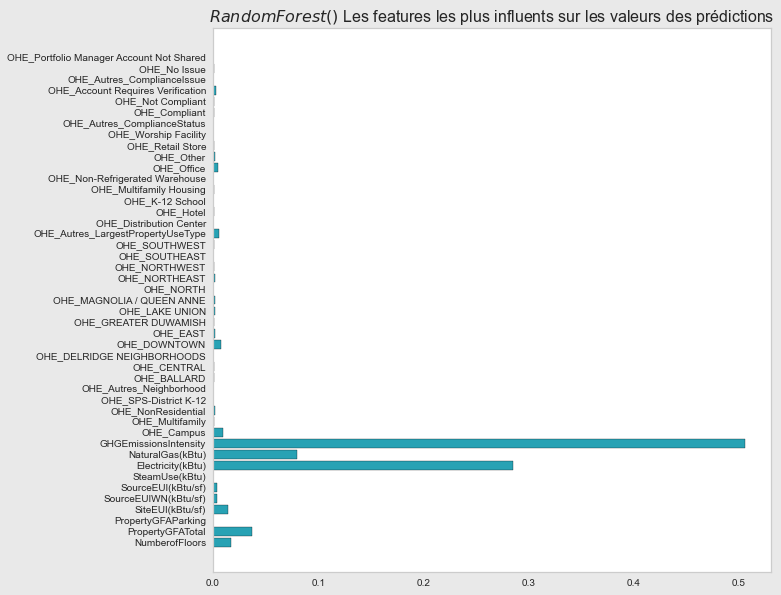

In [31]:
modelRandomForest=RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_leaf= 1, min_samples_split= 2)
modelRandomForest.fit(X_train,Y_train)
fig=plt.figure(figsize=[10,10])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.title("$RandomForest()$ Les features les plus influents sur les valeurs des prédictions",size=16)
plt.barh(X.columns, modelRandomForest.feature_importances_,color="#28a2b4",edgecolor='black')
plt.grid()

Le modèle RandomForestRegressor() montre que les features les plus participatives à la prédiction des variables targets sont : **GHCEmissionsIntensity**, **Electricity** et **NaturalGas(kBtu)**.

### Courbe d'apprentissage du modèle RandomForestRegressor() ? <a class="anchor" id="LearningCurveRF"></a>

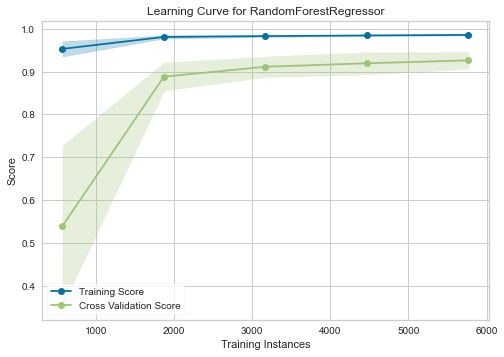

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [32]:
visualizer = LearningCurve(RandomForestRegressor(n_estimators=200, random_state=42), scoring='r2', random_state=42)

visualizer.fit(X, log_y)        # Fit the data to the visualizer
visualizer.show()

L'utilité de cette courbe est qu'elle montre la performance du modèle sur les données d'entraînement en fonction de la quantité de données d'entraînement utilisées. Elle est utilisée pour déterminer si le modèle est capable d'apprendre à partir des données d'entraînement et si la performance du modèle est suffisante. En général, on s'attend à ce que la performance du modèle sur les données d'entraînement augmente avec la quantité de données d'entraînement utilisées, car plus il y a de données d'entraînement, plus le modèle a l'occasion de s'ajuster.

La figure ci-dessus montre qu'à partir d'une taille des données d'entrainement de 2000, le modèle n'apprend plus la performance du modèle ne s'accroît plus.

### Prédiction et tabulation de quelques valeurs avec la métrique MSE <a class="anchor" id="PredictRF"></a>

In [33]:
a=pd.DataFrame(y_pred)
a.columns=['TotalGHGEmissions_Pred','SiteEnergyUse(kBtu)_Pred']
a.index=Y_test.index
a[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]=Y_test
a

,TotalGHGEmissions_Pred,SiteEnergyUse(kBtu)_Pred,TotalGHGEmissions,SiteEnergyUse(kBtu)
6175,2.638650,14.712945,2.442347,14.612413
2126,4.256059,14.513452,4.317488,14.604271
1160,4.271286,14.367136,4.410371,14.414204
6318,1.331726,13.398560,1.252763,13.415843
6809,4.539561,15.527923,4.067316,14.900024
...,...,...,...,...
1839,1.915703,14.010357,2.001480,14.007872
1758,2.371202,13.646224,2.406945,13.632459
729,4.070049,15.017223,3.883624,14.899876
7104,3.192724,13.730851,3.198673,13.737099


### Visualisation des prédictions pour chaque target

#### Pour la consommation d'énergie par les bâtiments '$SiteEnergyUse(kBtu)_Pred$'

Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $SiteEnergyUse(kBtu)$')

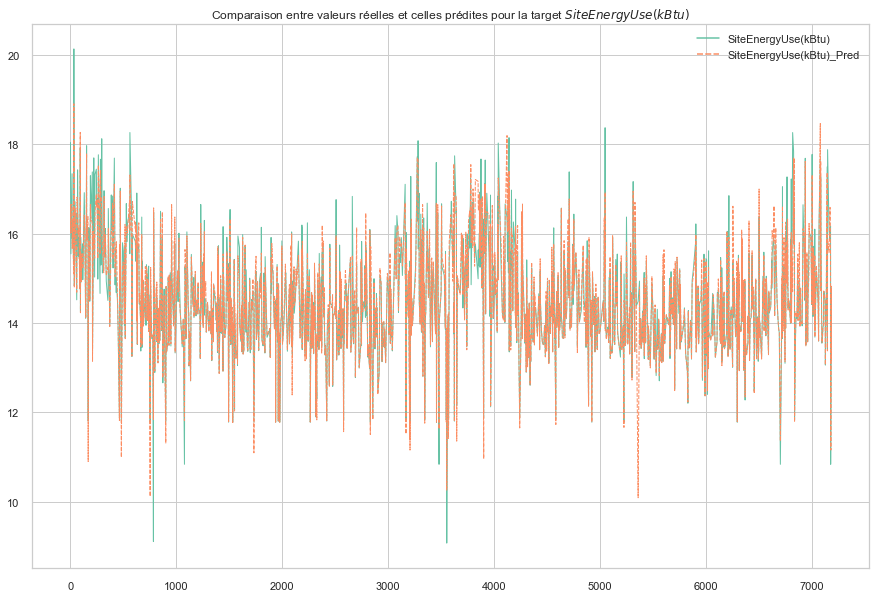

In [34]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=a[['SiteEnergyUse(kBtu)','SiteEnergyUse(kBtu)_Pred']],palette="Set2", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $SiteEnergyUse(kBtu)$")

#### Pour les  émissions de gaz à effet de serre '$TotalGHGEmissions$'

Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$')

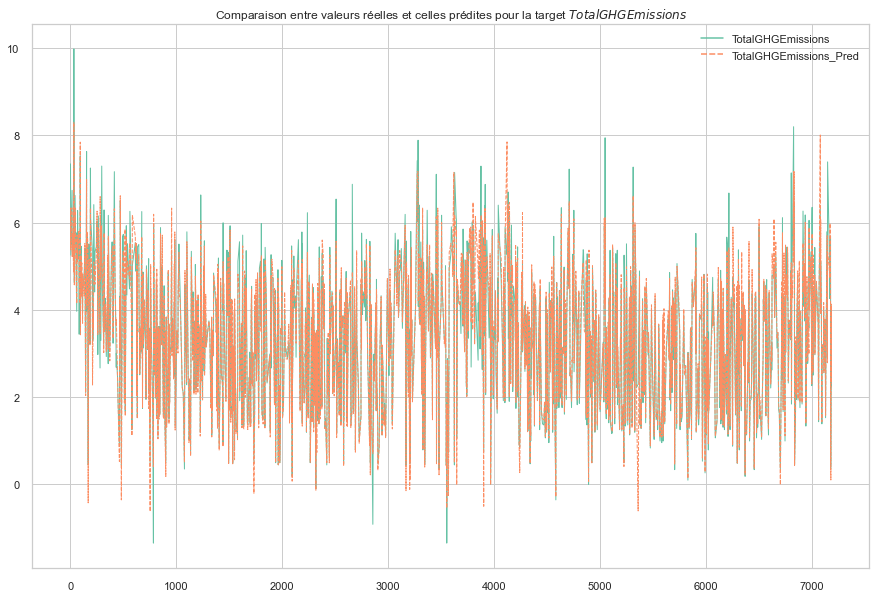

In [35]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=a[['TotalGHGEmissions','TotalGHGEmissions_Pred']],palette="Set2", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$")

Nous constatons de bonnes prédictions pour les deux targets. Les valeurs prédites suivent la même tendance que les valeurs réelles.

<a class="anchor" id="ridgereg"></a>

<img src=RidgeRegression.jpg />

### Score (train et test) et métriques && Tuning des hyperparamètres <a class="anchor" id="ScoreMetrHyperRR"></a>

In [36]:
for i in Y.columns:
    X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=45)
    param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}

    model = Ridge()

    grid_search2 = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

    grid_search2.fit(X_train, Y_train)
    
    print("For ",i)
    print(grid_search2.best_params_)
    y_pred = grid_search2.best_estimator_.predict(X_test)
    rmse_test = np.sqrt(MSE(Y_test, y_pred))
    print("RMSE : ", np.round(rmse_test, 2))
    print("Score d'entrainement", grid_search2.best_estimator_.score(X_train,Y_train))
    print("Score pour la prédiction", grid_search2.best_estimator_.score(X_test, Y_test))
    if i=="TotalGHGEmissions":
        a=pd.DataFrame(y_pred)
        a.index=Y_test.index
        a.columns=["Y_predicted"]
        a=pd.concat([Y_test,a],axis=1)
        a["MSE"]=abs(a.iloc[:,0]-a.iloc[:,1])/a.shape[0]
    else:
        b=pd.DataFrame(y_pred)
        b.index=Y_test.index
        b.columns=["Y_predicted"]
        b=pd.concat([Y_test,b],axis=1)
        b["MSE"]=abs(b.iloc[:,0]-b.iloc[:,1])/b.shape[0]
    print("="*75)
    print(a)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.84028e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.9167e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02358e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00218e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning

For  TotalGHGEmissions
{'alpha': 5}
RMSE :  0.93
Score d'entrainement 0.6520583843623341
Score pour la prédiction 0.6541390533022392
      TotalGHGEmissions  Y_predicted       MSE
6175           2.442347     2.994069  0.000383
2126           4.317488     3.375126  0.000654
1160           4.410371     4.644225  0.000162
6318           1.252763     1.202411  0.000035
6809           4.067316     3.900337  0.000116
...                 ...          ...       ...
1839           2.001480     2.177513  0.000122
1758           2.406945     2.058509  0.000242
729            3.883624     4.830072  0.000656
7104           3.198673     3.122549  0.000053
3019           4.426044     4.996740  0.000396

[1442 rows x 3 columns]


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.84028e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.9167e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02358e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00218e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning

For  SiteEnergyUse(kBtu)
{'alpha': 1}
RMSE :  0.75
Score d'entrainement 0.6055013784024387
Score pour la prédiction 0.6083465127567926
      TotalGHGEmissions  Y_predicted       MSE
6175           2.442347     2.994069  0.000383
2126           4.317488     3.375126  0.000654
1160           4.410371     4.644225  0.000162
6318           1.252763     1.202411  0.000035
6809           4.067316     3.900337  0.000116
...                 ...          ...       ...
1839           2.001480     2.177513  0.000122
1758           2.406945     2.058509  0.000242
729            3.883624     4.830072  0.000656
7104           3.198673     3.122549  0.000053
3019           4.426044     4.996740  0.000396

[1442 rows x 3 columns]


Définissons à présent un cross validation sur nos deux modèles

Le grid search, pour le modèle **Ridge()**, nous propose comme meilleur paramètre
   
       alpha = 5 pour la target TotalGHGEmissions
       alpha = 1 pour la target SiteEnergyUse(kBtu)
   
Et nous constatons également une très légère amélioration des scores d'entrainement et de prédiction pour les deux targets.

### Les courbes d'apprentissage pour **Ridge()** <a class="anchor" id="LearningCRR"></a>

LearningCurve for $TotalGHGEmissions$


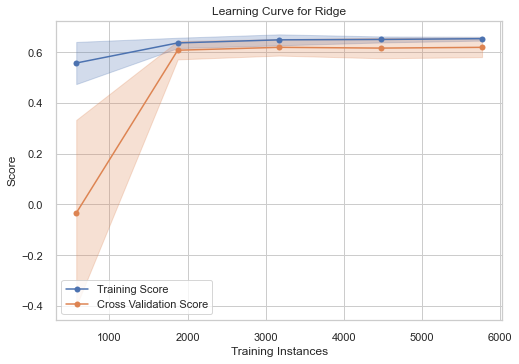

LearningCurve for $SiteEnergyUse(kBtu)$


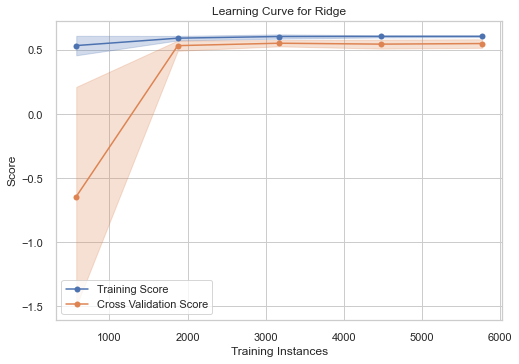

In [53]:
for i in log_y.columns:
    if (i=="TotalGHGEmissions"):
        param=5
    else:
        param=1
    print("LearningCurve for $"+i+"$")
    visualizer = LearningCurve(Ridge(alpha=param), scoring='r2', random_state=42)

    visualizer.fit(X, log_y[i])        # Fit the data to the visualizer
    visualizer.show()
    

### Features importance <a class="anchor" id="FImportRR"></a>

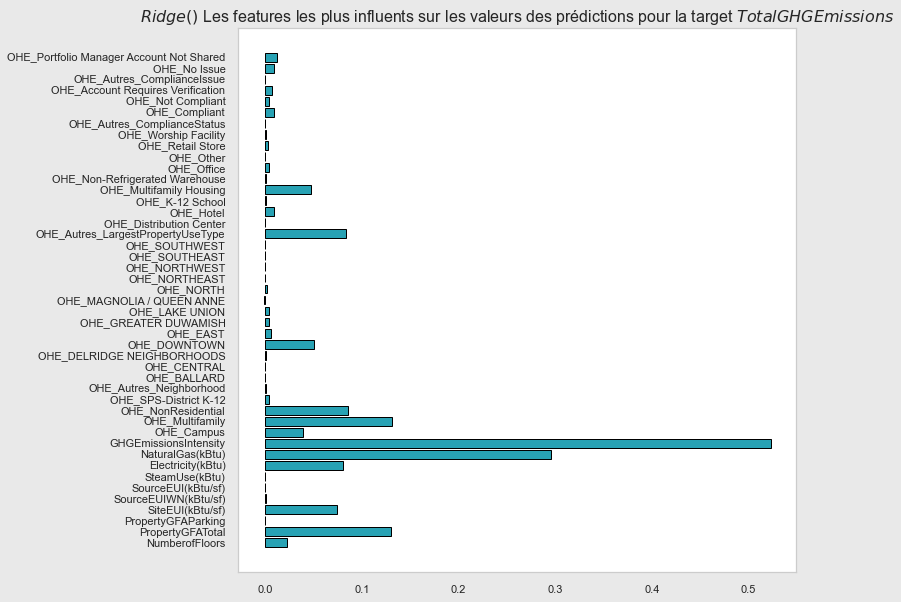

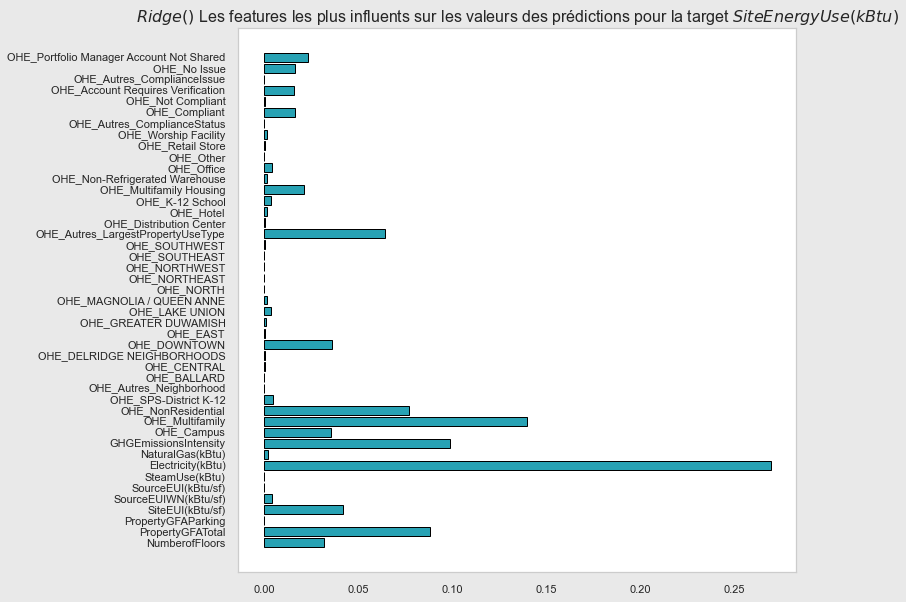

In [45]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

for i in log_y.columns:
    if (i=="TotalGHGEmissions"):
        param=5
    else:
        param=1
    X_train, X_test, Y_train, Y_test = train_test_split(X, log_y[i], test_size=0.2, random_state=45)
    model = Ridge(alpha=param)
    model.fit(X_train,Y_train)
    result = permutation_importance(model, X_train, Y_train, scoring='neg_mean_squared_error')
    fig=plt.figure(figsize=[10,10])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.title("$Ridge()$ Les features les plus influents sur les valeurs des prédictions pour la target $"+i+"$",size=16)
    plt.barh(X.columns,result.importances[:,0] ,color="#28a2b4",edgecolor='black')
    plt.grid()

Ridge nous informe que les features les plus déterminantes dans le prédiction des valeurs sont:
    
        1 - Pour la target $TotalGHGEmissions$ : GHCEmissionsIntensity et NaturelGas(kBtu) à respectivement près de 30% et plus de 50%.
        2 - Pour la target $SiteEnergyUse(kBtu)$ : Electricity (à plus de 25%)
            

### Prédiction et tabulation de quelques valeurs avec la métrique MSE <a class="anchor" id="PredictRR"></a>

Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$')

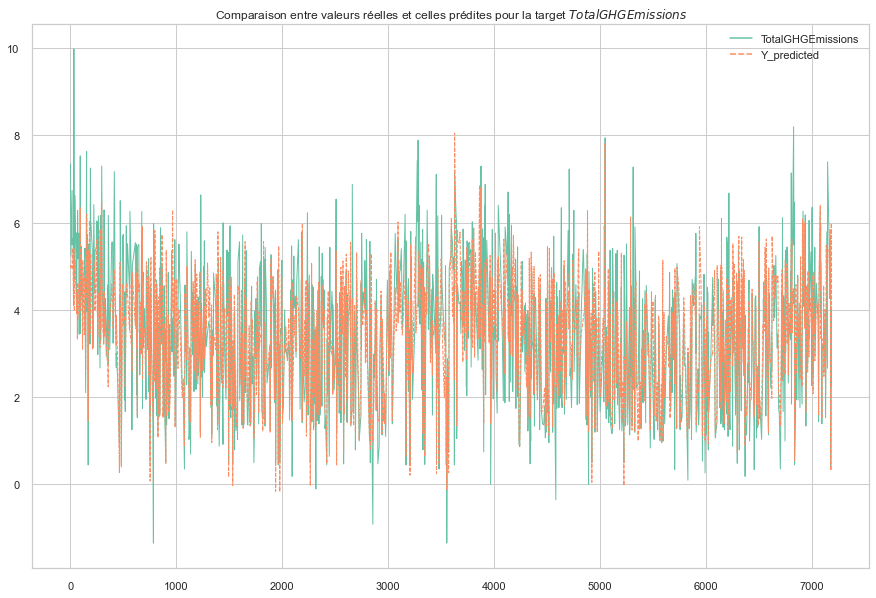

In [43]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=a[['TotalGHGEmissions','Y_predicted']],palette="Set2", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $TotalGHGEmissions$")

Text(0.5, 1.0, 'Comparaison entre valeurs réelles et celles prédites pour la target $SiteEnergyUse(kBtu)$')

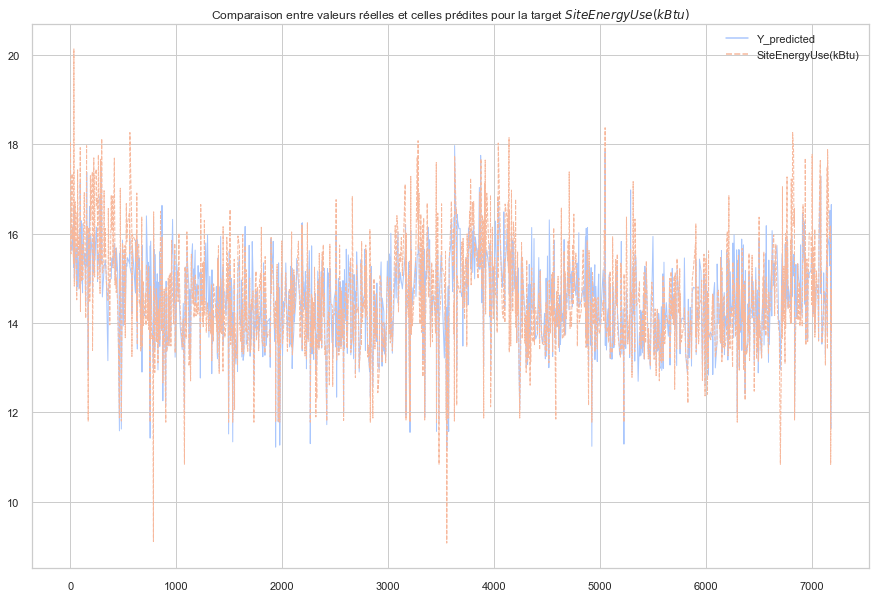

In [44]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.lineplot(data=b[['Y_predicted','SiteEnergyUse(kBtu)']], palette="coolwarm", linewidth=1)
plt.title("Comparaison entre valeurs réelles et celles prédites pour la target $SiteEnergyUse(kBtu)$")

Nous constatons effectivement que **Ridge** fait de bonnes prédictions.